In [84]:
%matplotlib inline

import os
from os import walk
from os.path import join as pjoin
import matplotlib.pyplot as plt
import geopandas as gpd
from Utilities import track
from shapely.geometry import LineString, Point
import numpy as np
import pandas as pd
import seaborn as sns
from cartopy import crs as ccrs
from cartopy import feature as cfeature
sns.set_style('whitegrid')
sns.set_context('talk')

In [85]:
states = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

In [86]:
def readTracks(trackFile):
    """
    Read a track file and create a `GeoPandas.GeoDataFrame` from the data, with
    separate polyline features for each unique track in the file. Also adds a
    nominal intensity category based on the central pressure value.

    :param str trackFile: Path to a TCRM-format track file

    :returns: `GeoPandas.GeoDataFrame` of tracks
    """
    tracks = track.ncReadTrackData(trackFile)
    trackgdf = []
    for t in tracks:
        segments = []
        for n in range(len(t.data) - 1):
            segment = LineString([[t.Longitude[n], t.Latitude[n]],[t.Longitude[n+1], t.Latitude[n+1]]])
            segments.append(segment)
        gdf = gpd.GeoDataFrame.from_records(t.data[:-1])
        gdf['geometry'] = segments
        gdf['category'] = pd.cut(gdf['CentralPressure'],
                                bins=[0, 930, 955, 970, 985, 990, 1020],
                                labels=[5,4,3,2,1,0])
        trackgdf.append(gdf)
    trackgdf = pd.concat(trackgdf)
    return trackgdf

In [87]:
filelist = []
datapath = r"C:\WorkSpace\tcrm\output\port_hedland\tracks"
plotpath = r"C:\WorkSpace\tcrm\output\port_hedland\plots\stats"

for (dirpath, dirnames, filenames) in walk(datapath):
    filelist.extend([fn for fn in filenames if fn.endswith('nc')])
    break
nfiles = len(filelist)
print(f"There are {nfiles} track files")

There are 100 track files


In [101]:
tracks = readTracks(pjoin(datapath, filelist[9]))

In [102]:
tracks.head()

,CycloneNumber,Datetime,TimeElapsed,Longitude,Latitude,Speed,Bearing,CentralPressure,EnvPressure,rMax,geometry,category
0,0,2656-03-01 07:00:00,0.0,82.000000,-10.500000,12.942880,177.000000,1000.799988,1007.861938,42.453114,"LINESTRING (82.00000 -10.50000, 82.00620 -10.6...",0
1,0,2656-03-01 08:00:00,1.0,82.006203,-10.616312,13.142924,172.666519,999.540710,1007.779419,44.912384,"LINESTRING (82.00620 -10.61631, 82.02157 -10.7...",0
2,0,2656-03-01 09:00:00,2.0,82.021568,-10.733616,10.947191,155.279633,999.331604,1007.771362,44.746025,"LINESTRING (82.02157 -10.73362, 82.06351 -10.8...",0
3,0,2656-03-01 10:00:00,3.0,82.063515,-10.823097,10.448412,162.866348,996.887268,1007.586121,42.797443,"LINESTRING (82.06351 -10.82310, 82.09173 -10.9...",0
4,0,2656-03-01 11:00:00,4.0,82.091728,-10.912947,12.412211,152.824844,996.808899,1007.591736,42.735165,"LINESTRING (82.09173 -10.91295, 82.14370 -11.0...",0


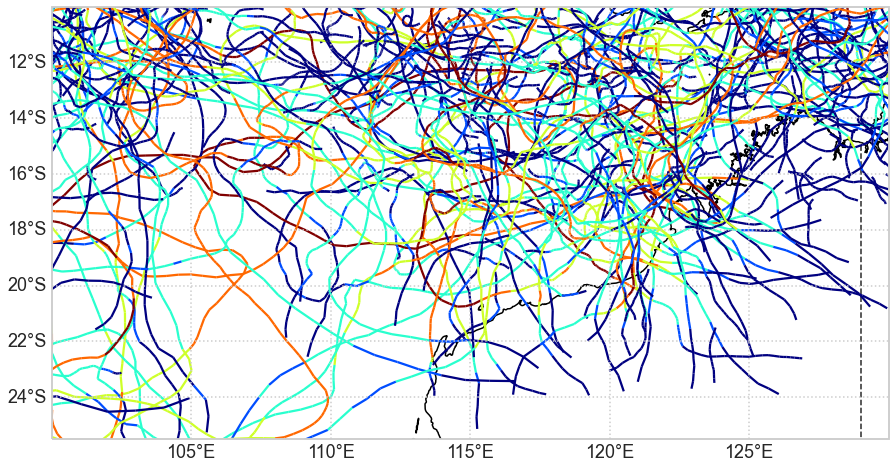

In [103]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.figure.set_size_inches(15, 12)
tracks.plot(ax=ax, column='category', cmap='jet_r')
ax.coastlines(resolution='10m')
ax.add_feature(states, edgecolor='0.15', linestyle='--')
gl = ax.gridlines(draw_labels=True, linestyle=":")
gl.top_labels = False
gl.right_labels = False
ax.set_extent((100, 130, -25, -10))

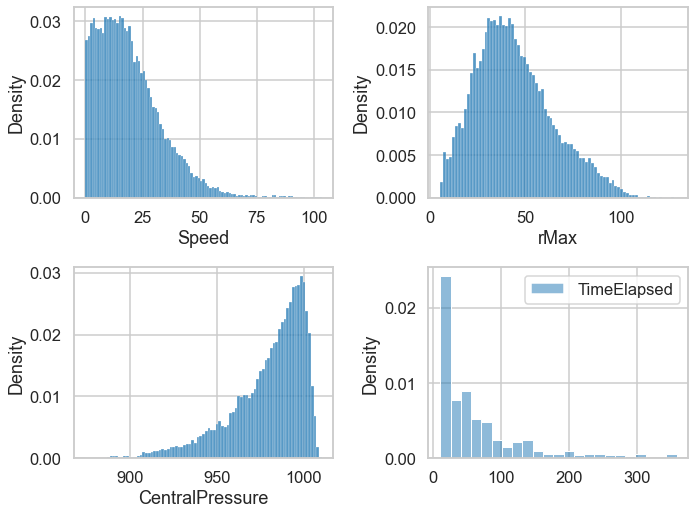

In [104]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7.5))
sns.histplot(data=tracks.Speed, stat='density', ax=axes[0, 0])
sns.histplot(data=tracks.rMax, stat='density', ax=axes[0, 1])
sns.histplot(data=tracks.CentralPressure, stat='density', ax=axes[1, 0])
age = tracks.groupby('CycloneNumber').agg({'TimeElapsed': 'max'})
sns.histplot(data=age, stat='density', ax=axes[1, 1])
fig.tight_layout()